# **Notebook3**
## **Feature Management**

## **Table of Contents**

* [1. Introduction](#1.)

* [2. Importing](#2)
    * [2.1 Importing Libraries](#2.1)
    * [2.2 Importing Datasets](#2.2)

* [3. Data Exploration and Treatment](#3.)
    * [3.1. Feature Engineering](#3.1.)

     * [2.2.1 Numerical Data](#2.2.1)
    * [2.2.2 Categorical Data](#2.2.2)
    * [2.3 Feature Engineering](#2.3)
    * [2.4 Data Partitioning](#2.4)
    * [2.5 Encoding](#2.5)
    * [2.6 Scaling](#2.6)


## **1. Introduction**
This notebook executes the core **Feature Engineering** phase by performing two critical operations: splitting the data and applying statistical transformations in a controlled, non-leaking sequence. Since we are **not using a Scikit-learn Pipeline**, all transformation steps (Imputation, Scaling, Encoding) must be manually fitted and applied.

### Anti-Leakage Protocol: Split First
1.  **Split Data First:** The structurally cleaned dataset is first divided into dedicated Training, Validation, and Test sets.
2.  **Fit on Training Only:** All statistical transformers (`SimpleImputer`, `StandardScaler`, `OneHotEncoder`) are then **fitted exclusively on the Training set**.
3.  **Transform All:** The parameters learned solely from the Training set are applied to transform the Training, Validation, and Test sets.

This explicit, manual sequencing guarantees that no information from the Test or Validation set contaminates the Training process.

### Objectives
The objectives are:
* **Data Splitting:** Divide the dataset into 60% Training, 20% Validation, and 20% Test sets using a stratified approach to maintain class balance (`OK`/`KO`) in all partitions.
* **Imputation:** Manually fit and transform the data, filling missing values in numerical features using the median calculated only from the Training data.
* **Scaling:** Manually fit and transform the numerical features using the `StandardScaler`, with its mean ($\mu$) and standard deviation ($\sigma$) calculated only from the Training data.
* **Encoding:** Manually fit and transform the categorical feature (`origin`) using `OneHotEncoder` based only on the unique categories present in the Training data.
* **Export:** Save the fully transformed data splits and the fitted transformer objects for direct use by the **Modelling (NB4)** and **Final Model (NB9)** notebooks.

## **2. Importing Section**

### **2.1. Importing Libraries**

In [1]:
#Importing necessary libraries
import pandas as pd
import numpy as np
import pickle, os
import matplotlib.pyplot as plt
import seaborn as sns

# Data partitioning
from sklearn.model_selection import train_test_split, StratifiedKFold 

# Imputation
from sklearn.impute import SimpleImputer

# Encoding
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# Scaling methods
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

#Machine Learning Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

#Model Evaluation Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

#Feature Selection
from sklearn.feature_selection import RFE
from sklearn.linear_model import LassoCV
import scipy.stats as stats

#Suppress warnings
import warnings
warnings.filterwarnings('ignore')

### **2.2. Importing the Learn and Predict Dataset**

In [2]:
'''Loading the cleaned learning dataset'''
learn_clean = pd.read_csv('datasetlearn_cleaned.csv', sep = ',', index_col = 0) #The reference to index_col=0 is to avoid the creation of an extra index column which would cause issues later on
display(learn_clean.shape)
learn_clean.head()

(5199, 15)

,ambient_humidity,baking_duration,cooling_period,cream_fat_content,egg_temperature,egg_yolk_count,final_temperature,lemon_zest_ph,origin,oven_temperature,preheating_time,salt_ratio,sugar_content,vanilla_extract,quality_class_binary
id,,,,,,,,,,,,,,,
1,54.0,24.0,26.0,100.4,52.0,11.0,309.0,3.2,Lisboa,NaN,207.0,42.74,22.8,5.7,0
2,66.0,37.0,34.0,98.0,46.0,10.0,317.0,3.3,Lisboa,306.0,245.0,41.73,11.6,4.0,0
3,41.0,30.0,19.0,99.3,53.0,10.0,130.0,3.4,Porto,121.0,186.0,75.10,20.3,7.5,1
4,62.0,24.0,48.0,98.0,115.0,9.0,354.0,3.3,Lisboa,357.0,186.0,46.41,73.3,4.2,1
5,55.0,21.0,34.0,100.1,48.0,9.0,211.0,3.0,Lisboa,202.0,218.0,56.52,80.1,6.0,0


&nbsp;&nbsp;&nbsp;&nbsp; The `predict.csv` dataset (unseen data)  needs to go through the same transformations applied previously to the training data. That way, we **guarantee consistency** between all datasets.
The Machine Learning model must receive all the datasets with the **same format**: the same columns on the same scales and with the same categorical encodings used during the training phase.


In [3]:
'''Loading the prediction dataset'''
predict_data = pd.read_csv('Nata_Files/predict.csv', sep = ',', index_col = 0)
display(predict_data.shape)
predict_data.head()

(1300, 16)

,ambient_humidity,baking_duration,cooling_period,cream_fat_content,egg_temperature,egg_yolk_count,final_temperature,lemon_zest_ph,notes_baker,origin,oven_temperature,pastry_type,preheating_time,salt_ratio,sugar_content,vanilla_extract
id,,,,,,,,,,,,,,,,
5201,79.0,22,40,98.6,79.0,9.0,259.0,3.2,NaN,Lisboa,268.0,NaN,208.0,49.63,182.6,4.0
5202,49.0,26,32,101.9,105.0,9.0,287.0,3.2,NaN,Lisboa,287.0,Pastel de nata,189.0,182.54,76.2,4.8
5203,80.0,28,24,96.6,20.0,10.0,64.0,3.4,NaN,Porto,74.0,Pastel Nata,201.0,100.41,23.5,6.1
5204,74.0,21,37,97.2,81.0,9.0,314.0,3.0,NaN,Lisboa,317.0,NaN,220.0,46.66,143.2,4.9
5205,41.0,19,41,97.3,104.0,10.0,246.0,3.2,NaN,Lisboa,243.0,Pastel Nata,191.0,39.45,143.0,7.0


In [4]:
''' 
We will use the same logic as in notebook 2 to clean the prediction dataset.
Firstly, we will drop the unneeded columns and then get rid of inconsistencies in the 'origin' column
'''
predict_data = predict_data.drop(columns=[ 'notes_baker', 'pastry_type']) 
predict_data['origin'] = predict_data['origin'].str.strip().str.lower().str.title()
print(predict_data['origin'].unique()) #just to check if it worked

['Lisboa' 'Porto' nan]


## **3. Data Exploration and Treatment**

### **3.1. Dealing with Impossible Values**

While analysing our dataset and our features, we found there were some  **physically impossible values** that can represent data entry errors or sensor malfuncstions.

Therefore, we defined the following domain constraints:
1.  **Percentages (Humidity & Fat):** Must be between 0% and 100%.
2.  **pH Scale:** Must be between 0 and 14.
3.  **Physical Dimensions (Time/Temp):** Must be non-negative.

**Treatment Strategy:**

Instead of dropping these rows, as we would lose valuable information, we **convert these 'errors' to `NaN`** (Missing Values). These will be handled later on.

**Note:** In cases where values exceeded the constrained limits, capping them at those thresholds would introduce a larger error compared to median imputation. Additionally, capping would create an artificial 'spike' in the data at those thresholds, distorting the feature's distribution.

In [10]:
'''
In the descriptive statistics of notebook 1, we verified that there were no negative number in the dataset. 
Therefore, we will not check for impossible values for that constraint.
'''
# 1st Constraint: Percentages (0 to 100)
impossible_humidityL = learn_clean[(learn_clean['ambient_humidity'] > 100) | (learn_clean['ambient_humidity'] < 0)]
impossible_fatL = learn_clean[(learn_clean['cream_fat_content'] > 100) | (learn_clean['cream_fat_content'] < 0)]

impossible_humidityP = predict_data[(predict_data['ambient_humidity'] > 100) | (predict_data['ambient_humidity'] < 0)]
impossible_fatP = predict_data[(predict_data['cream_fat_content'] > 100) | (predict_data['cream_fat_content'] < 0)]

# 2nd Constraint: pH Scale (0 to 14)
impossible_phL = learn_clean[(learn_clean['lemon_zest_ph'] > 14) | (learn_clean['lemon_zest_ph'] < 0)]
impossible_phP = predict_data[(predict_data['lemon_zest_ph'] > 14) | (predict_data['lemon_zest_ph'] < 0)]

print(f"Impossible Humidity rows in learn_clean: {len(impossible_humidityL)}")
print(f"Impossible Humidity rows in predict_data: {len(impossible_humidityP)}")

print(f"Impossible Fat rows: {len(impossible_fatL)}")
print(f"Impossible Fat rows in predict_data: {len(impossible_fatP)}")

print(f"Impossible pH rows: {len(impossible_phL)}")
print(f"Impossible pH rows in predict_data: {len(impossible_phP)}")

Impossible Humidity rows in learn_clean: 0
Impossible Humidity rows in predict_data: 0
Impossible Fat rows: 1099
Impossible Fat rows in predict_data: 281
Impossible pH rows: 0
Impossible pH rows in predict_data: 0


In [15]:
'''
We will just replace the values in cream fat content as it is the only feature with impossible values found (in both datasets).
'''
learn_clean.loc[impossible_fatL.index, 'cream_fat_content'] = np.nan
predict_data.loc[impossible_fatP.index, 'cream_fat_content'] = np.nan

### **3.2. Feature Engineering**

&nbsp;&nbsp;&nbsp;&nbsp;To better capture the interaction between ingredients and the baking process, we decided to **create two new features**.

* **`sugar_fat_ratio`**:
    This captures the relative proportion of two key ingredients: `sugar_content` and `cream_fat_content`. A small constant ($1e^{-6}$) was added to prevent errors due to divison by zero in cases where fat content might be zero or missing. 

    
* **`baking_intensity`**:
    By multiplying `baking_duration` by `oven_temperature`, we are able to quantify the overall heat exposure the product underwent during the baking process. This allows the model to dstinguish between a 'short but high' heat and a 'long but low' heat.



In [16]:
'''These transformations were applied consistently to both the training and prediction datasets, for the reasons we said above.'''

#Original Dataset
learn_clean['sugar_fat_ratio'] = learn_clean['sugar_content'] / (learn_clean['cream_fat_content'] + 1e-6)  # the small constant to avoid division by zero
learn_clean['baking_intensity'] = learn_clean['baking_duration'] * learn_clean['oven_temperature']

#Predict Dataset
predict_data['sugar_fat_ratio'] = predict_data['sugar_content'] / (predict_data['cream_fat_content'] + 1e-6)
predict_data['baking_intensity'] = predict_data['baking_duration'] * predict_data['oven_temperature']

### **3.3. Data Partitioning**

In [17]:
X = learn_clean.drop('quality_class_binary',axis = 1)
y = learn_clean['quality_class_binary']

In [18]:
X_train, X_rest, y_train, y_rest = train_test_split(X, y, train_size = 0.7,shuffle = True, random_state=42, stratify=y)

X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=0.5, shuffle = True, random_state=42, stratify=y_rest)

In [19]:
print('train:{}% | validation:{}% | test:{}%'.format(round(len(y_train)/len(y),2),
                                                     round(len(y_val)/len(y),2),
                                                     round(len(y_test)/len(y),2)
                                                    ))

train:0.7% | validation:0.15% | test:0.15%


### Dealing with impossible values

### **Separate Numerical and Categorical**

In [ ]:
numerical_features = X.select_dtypes(include = np.number).columns.tolist()
categorical_features = X.select_dtypes(exclude = np.number).columns.tolist()



In [21]:
print("Numerical Features:", numerical_features)

Numerical Features: ['ambient_humidity', 'baking_duration', 'cooling_period', 'cream_fat_content', 'egg_temperature', 'egg_yolk_count', 'final_temperature', 'lemon_zest_ph', 'oven_temperature', 'preheating_time', 'salt_ratio', 'sugar_content', 'vanilla_extract', 'sugar_fat_ratio', 'baking_intensity']


In [22]:
X_train_num = X_train.select_dtypes(include = np.number)
X_val_num = X_val.select_dtypes(include = np.number)
X_test_num = X_test.select_dtypes(include = np.number)

X_predict_num = predict_data.select_dtypes(include = np.number)

In [23]:
X_train_cat = X_train.select_dtypes(exclude = np.number)
X_val_cat = X_val.select_dtypes(exclude = np.number)
X_test_cat = X_test.select_dtypes(exclude = np.number)

X_predict_cat = predict_data.select_dtypes(exclude = np.number)

### **Imputation**

In [24]:
imputer = SimpleImputer(strategy='median')
imputer.fit(X_train_num)

,missing_values,nan
,strategy,'median'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False


In [25]:
# Transform all splits using the median learned from the training data
X_train_num.loc[:, :] = imputer.transform(X_train_num) 
X_val_num.loc[:, :] = imputer.transform(X_val_num)
X_test_num.loc[:, :] = imputer.transform(X_test_num)

X_predict_num.loc[:, :] = imputer.transform(X_predict_num)

### Encoding

In [26]:
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False) #if an unseen category appears in the test or prediction data, the encoder will safely ignore it, maintaining the correct column structure.

encoder.fit(X_train_cat)

#Training Data
X_train_cat_encoded = encoder.transform(X_train_cat)
X_train_cat_encoded = pd.DataFrame(X_train_cat_encoded, columns = encoder.get_feature_names_out(categorical_features), index = X_train_cat.index)

#Validation Data
X_val_cat_encoded = encoder.transform(X_val_cat)
X_val_cat_encoded = pd.DataFrame(X_val_cat_encoded, columns = encoder.get_feature_names_out(categorical_features), index = X_val_cat.index)

#Testing Data
X_test_cat_encoded = encoder.transform(X_test_cat)  
X_test_cat_encoded = pd.DataFrame(X_test_cat_encoded, columns = encoder.get_feature_names_out(categorical_features), index = X_test_cat.index)

#Prediction Data
X_predict_cat_encoded = encoder.transform(X_predict_cat)
X_predict_cat_encoded = pd.DataFrame(X_predict_cat_encoded, columns = encoder.get_feature_names_out(categorical_features), index = X_predict_cat.index)

### Scaling

In [27]:
scaler = RobustScaler()
#Fitting the scaler on the training data
scaler.fit(X_train_num)

#Transforming training data
X_train_scaled = scaler.transform(X_train_num)
X_train_scaled = pd.DataFrame(X_train_scaled, columns = numerical_features, index = X_train_num.index)

#Transforming validation data
X_val_scaled = scaler.transform(X_val_num)
X_val_scaled = pd.DataFrame(X_val_scaled, columns = numerical_features, index = X_val_num.index)

#Transforming testing data
X_test_scaled = scaler.transform(X_test_num)
X_test_scaled = pd.DataFrame(X_test_scaled, columns = numerical_features, index = X_test_num.index)

#Transforming prediction data
X_predict_scaled = scaler.transform(X_predict_num[numerical_features])
X_predict_scaled = pd.DataFrame(X_predict_scaled, columns = numerical_features, index = X_predict_num.index)

### Feature Selection

#### Filter Methods

Univariate Varaibles

In [28]:
X_train_scaled.var().sort_values()

ambient_humidity     0.338219
final_temperature    0.514154
egg_temperature      0.514358
oven_temperature     0.545273
sugar_content        0.571933
baking_intensity     0.595425
lemon_zest_ph        0.690131
vanilla_extract      0.764231
cream_fat_content    0.798007
baking_duration      0.860913
sugar_fat_ratio      0.861861
preheating_time      0.997719
cooling_period       1.073395
egg_yolk_count       1.548949
salt_ratio           1.634721
dtype: float64

Spearmans Correlation

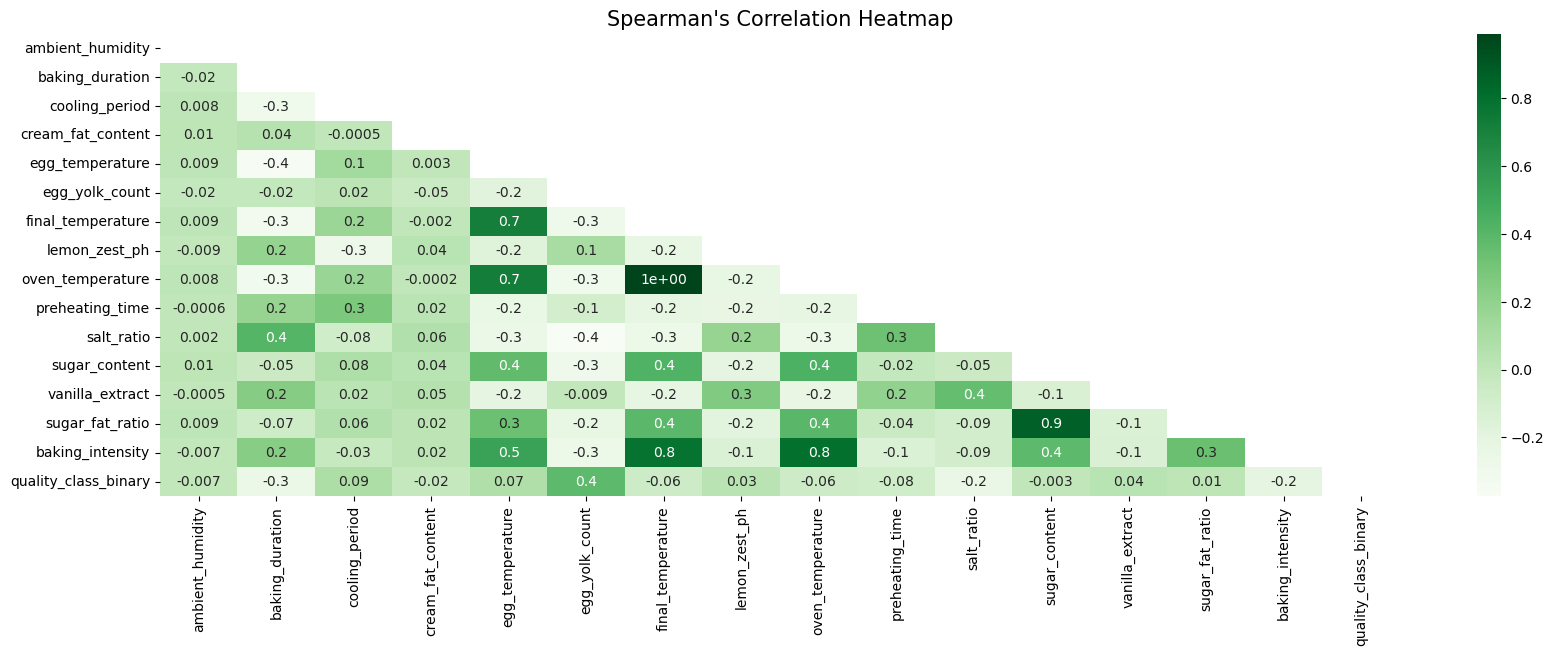

In [29]:
# Joining the numeric observations with the outcome
all_train_numerical = X_train_scaled.join(y_train)

# Computing Spearman's Correlation
correlation = all_train_numerical.corr(method = 'spearman')

# Plotting the lower triangle of the correlation map
def corr_heatmap(correlation):
    plt.figure(figsize=(20, 6))
    ax = sns.heatmap(data = correlation, annot = True, mask = np.triu(np.ones_like(correlation)), cmap = 'Greens', fmt = '.1')
    ax.set_title("Spearman's Correlation Heatmap", fontdict = {'fontsize': 15})
    plt.show()

corr_heatmap(correlation)

nao ha nehuma assim muito related

In [30]:
def TestIndependence(X,y,var,alpha=0.05):
    dfObserved = pd.crosstab(y,X)
    chi2, p, dof, expected = stats.chi2_contingency(dfObserved.values)
    dfExpected = pd.DataFrame(expected, columns=dfObserved.columns, index = dfObserved.index)
    if p<alpha:
        result = "{0} is an IMPORTANT predictor".format(var)
    else:
        result = "{0} is NOT an important predictor. (Discard {0} from model)".format(var)
    print(result)

In [31]:
for variable in X_train_cat.columns:
    TestIndependence(X_train_cat[variable], y_train, variable)

origin is an IMPORTANT predictor


### Wrapper Methods

In [32]:
model = LogisticRegression()

RFE

In [33]:
# Number of features
nof_list = np.arange(1,8)
high_score = 0

# Variable to store the optimum features
nof = 0
score_list = []
for n in range(len(nof_list)):
    rfe = RFE(model,n_features_to_select = nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train_scaled,y_train)
    X_val_rfe = rfe.transform(X_val_scaled)
    model.fit(X_train_rfe,y_train)

    score = model.score(X_val_rfe,y_val)
    score_list.append(score)

    if(score > high_score):
        high_score = score
        nof = nof_list[n]

print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features: 4
Score with 4 features: 0.737179


In [34]:
rfe = RFE(estimator = model, n_features_to_select = nof)
rfe_fitted = rfe.fit_transform(X_train_scaled, y_train)
selected_features = pd.Series(rfe.support_, index = X_train_scaled.columns)
selected_features

ambient_humidity     False
baking_duration      False
cooling_period       False
cream_fat_content    False
egg_temperature      False
egg_yolk_count        True
final_temperature     True
lemon_zest_ph        False
oven_temperature      True
preheating_time      False
salt_ratio           False
sugar_content        False
vanilla_extract      False
sugar_fat_ratio      False
baking_intensity      True
dtype: bool

Embedding

Lasso

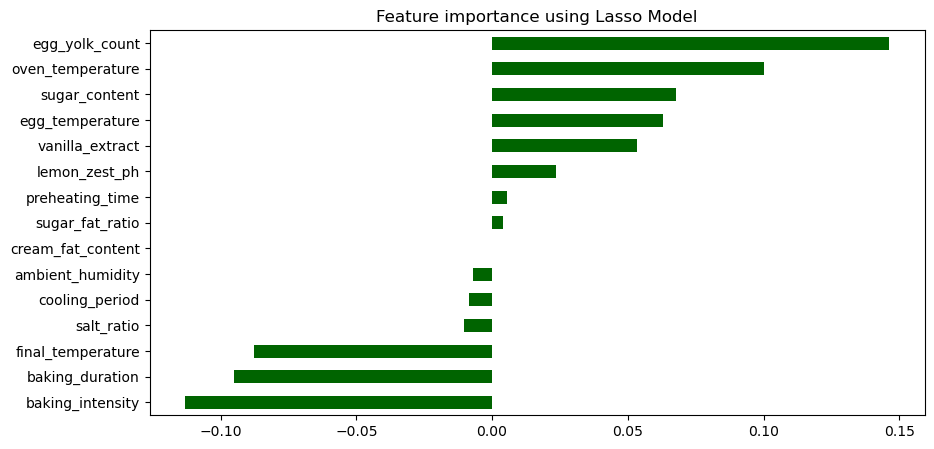

In [35]:
def plot_importance(coef,name):
    imp_coef = coef.sort_values()
    plt.figure(figsize = (10, 5))
    imp_coef.plot(kind = "barh", color = 'darkgreen')
    plt.title("Feature importance using " + name + " Model")
    plt.show()

reg = LassoCV()

reg.fit(X_train_scaled, y_train)

coef = pd.Series(reg.coef_, index = X_train_scaled.columns)

plot_importance(coef,'Lasso')

Decisison Tree

<Axes: xlabel='Value', ylabel='Features'>

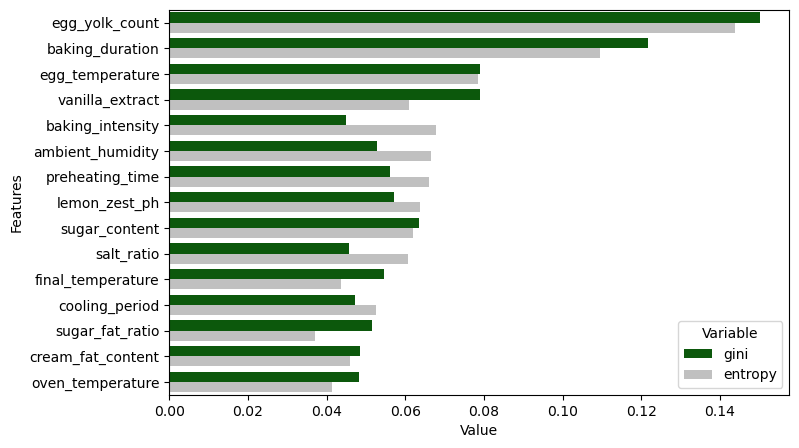

In [36]:
gini_importance = DecisionTreeClassifier(splitter='random', random_state=42).fit(X_train_scaled, y_train).feature_importances_
entropy_importance = DecisionTreeClassifier(criterion='entropy', splitter='random', random_state=42).fit(X_train_scaled, y_train).feature_importances_

zippy = pd.DataFrame(zip(gini_importance, entropy_importance), columns=['gini', 'entropy'])
zippy['Features'] = X_train_scaled.columns
tidy = zippy.melt(id_vars='Features').rename(columns=str.title)
tidy.sort_values(['Value'], ascending=False, inplace=True)

plt.figure(figsize=(8, 5))
sns.barplot(y='Features', x='Value', hue='Variable', data=tidy, palette=['darkgreen', 'silver'])

| Numerical Data |  Spearman's Correlation | RFE | Lasso | Decision Tree | Relevance |
| --- | --- | --- | --- | --- | --- | 
|  Egg Yolk Count | Keep ?? |  Keep | Keep| Keep | **Keep** |
|  Baking Duration | Discard |   Discard | Keep | Keep| **Keep** |
|  Egg temperature | Discard  | Discard| Keep | Keep | **Keep** |
|  Baking Intensity | Discard  |  Keep | Keep | Keep | **Keep** |
|  Lemon PH  | Discard |  Discard| Keep | Discard? | **Discard** |
| Vanilla Extract | Discard|Discard| Keep|Keep|**Keep**|
| Sugar Fat Ratio | Discard|Discard|Keep|Discard|**Discard**|
| Salt Ratio | Discard|Discard|Keep|Keep|**Keep**|
| Ambient Humidity |Discard|Discard|Discard??|Discard|**Discard**|
| Total Time |Discard|Discard|Keep|Keep|**Keep**|
| Sugar Content |Discard|Discard|Discard| Keep |**Try with and without**|
| Pre heating Time |Discard|Discard|Discard|Keep|**Try with and without**????|
| Cream Fat Content |Discard|Discard|Discard|Keep|**Try with and without** ????????|
| Final Temperature |Discard|Keep|Keep|Discard| ?????|
| Cooling Period |Discard|Discard|Discard??|Keep|**Keep**|
| Oven Temperature |Discard|Keep|Keep| Keep|**Keep**|


In [37]:
features_to_drop = ['ambient_humidity', 'sugar_fat_ratio', 'lemon_zest_ph']

print(f"Dropping these features globally: {features_to_drop}")

Dropping these features globally: ['ambient_humidity', 'sugar_fat_ratio', 'lemon_zest_ph']


In [38]:
#TRAIN
X_train_final = pd.concat([X_train_scaled, X_train_cat_encoded], axis=1)

#VALIDATION
X_val_final = pd.concat([X_val_scaled, X_val_cat_encoded], axis=1)

#TEST
X_test_final = pd.concat([X_test_scaled, X_test_cat_encoded], axis=1)

#PREDICTION
X_predict_final = pd.concat([X_predict_scaled, X_predict_cat_encoded], axis=1)

In [39]:
X_train_final = X_train_final.drop(columns=features_to_drop, errors='ignore')
X_val_final   = X_val_final.drop(columns=features_to_drop, errors='ignore')
X_test_final  = X_test_final.drop(columns=features_to_drop, errors='ignore')
X_predict_final = X_predict_final.drop(columns=features_to_drop, errors='ignore')

In [40]:
#please make the pickle 
notebook3newww_data_fixed = {
    # Dataframes Transformados
    'X_train_final': X_train_final, 'y_train': y_train,
    'X_val_final': X_val_final, 'y_val': y_val,
    'X_test_final': X_test_final, 'y_test': y_test,
    # Dados de Previsão PRONTOS
    'X_predict_final': X_predict_final,
    'id_predict': predict_data.index,
    # Salvamos os transformadores AJUSTADOS (Anti-Leakage Keys)
    'imputer': imputer, 'scaler': scaler, 'encoder': encoder, 
    #'outlier_bounds': outlier_bounds, 
    'numerical_features': numerical_features, 'categorical_features': categorical_features
}

with open(r'Nata_Files\\notebook3newwwww.pkl', 'wb') as f:
    pickle.dump(notebook3newww_data_fixed, f)
    
print("Processing and export complete. Notebook 4 can be started.")


Processing and export complete. Notebook 4 can be started.
